In [2]:
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
from textstat import textstat
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [3]:
# Ensure src modules are importable
src_path = str((Path.cwd().parent / 'src').resolve())
if src_path not in sys.path:
    sys.path.append(src_path)

from src.plot import (
    plot_class_distribution,
    plot_feature_histogram,
    plot_wordcloud,
    plot_top_words_barchart,
    plot_corr_matrix
)
from src.utils import basic_clean, preprocess_text, get_sentiment

In [4]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Data Loading & Cleaning

In [5]:
data_dir = (Path.cwd().parent / 'data' / 'raw').resolve()
csv_path = data_dir / 'WELFake_Dataset.csv'

news = pd.read_csv(csv_path)
news.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
news.drop('Unnamed: 0',axis=1,inplace=True)
news.rename(columns={"label":"is_fake"},inplace=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    71576 non-null  object
 1   text     72095 non-null  object
 2   is_fake  72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [7]:
before = len(news)
na_rows = news['title'].isna() | news['text'].isna()
num_na = na_rows.sum()
pct_na = (num_na / before) * 100

dup_rows = news.duplicated(subset=['title', 'text'])
num_dup = dup_rows.sum()
pct_dup = (num_dup / before) * 100

news.dropna(subset=['title', 'text'], how='any', inplace=True)
news.drop_duplicates(subset=['title', 'text'], inplace=True)
news.reset_index(drop=True, inplace=True)
print(f"Dropped {num_na} rows with NA ({pct_na:.2f}%) and {num_dup} duplicate rows ({pct_dup:.2f}%).")


Dropped 597 rows with NA (0.83%) and 8456 duplicate rows (11.72%).


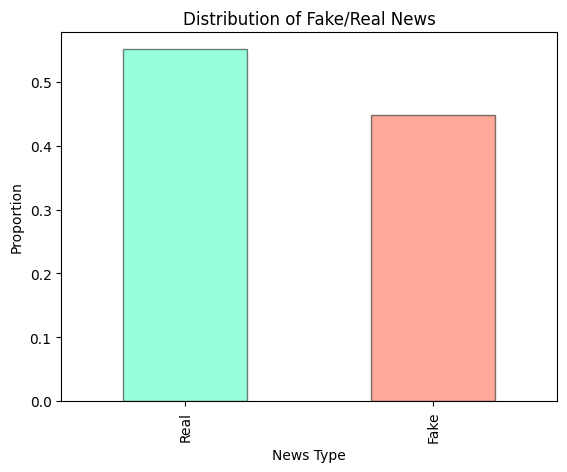

In [8]:
plot_class_distribution(news, 'is_fake')

## Text-Specific Explorations

In [9]:
news["raw_text"] = news["title"] + " " + news["text"]
news["clean_text"] = news["raw_text"].apply(basic_clean)
news["lemmatized_text"] = news["clean_text"].apply(preprocess_text)
news.head(3)

,title,text,is_fake,raw_text,clean_text,lemmatized_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement on high alert following threat...,law enforcement high alert following threat co...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obama s attorney general says mos...,unbelievable obama attorney general say charlo...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu uses story of christ...,bobby jindal raised hindu us story christian c...


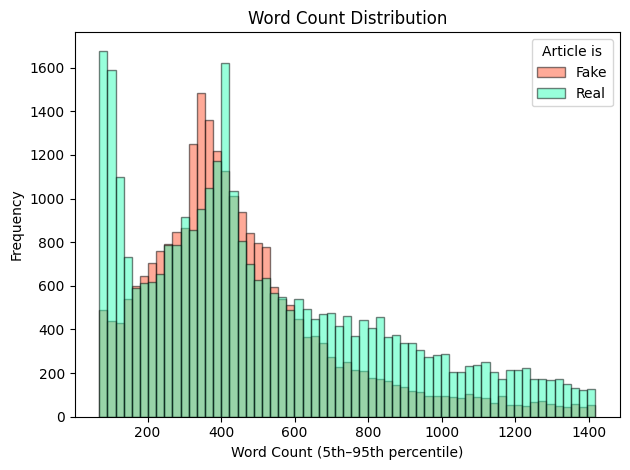

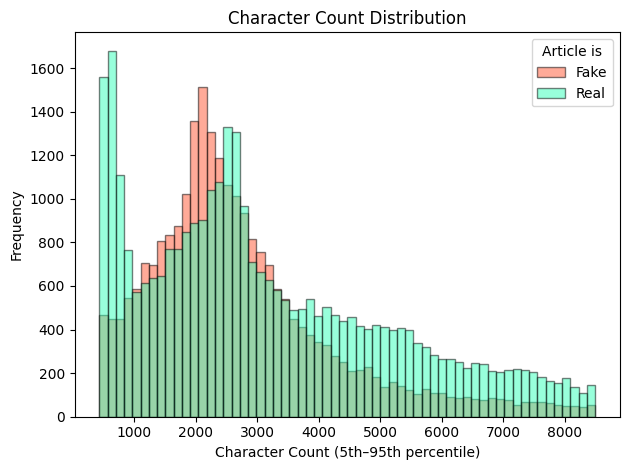

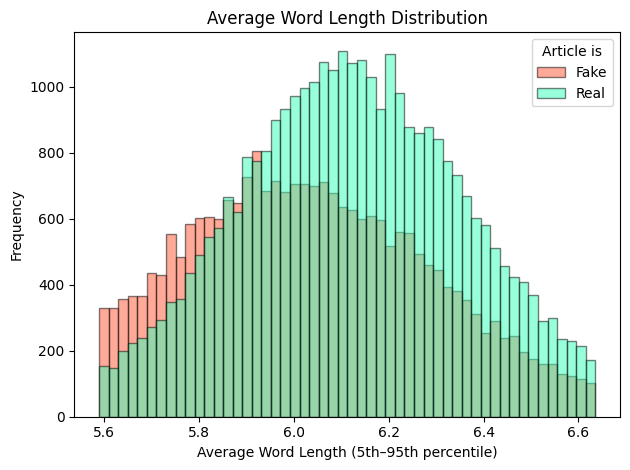

In [10]:
news['word_count'] = news["raw_text"].apply(lambda x: len(x.split()))
news["char_count"] = news["raw_text"].str.len()
news["avg_word_length"] = news["char_count"] / news["word_count"]

plot_feature_histogram(news, 'word_count', "Word Count Distribution", "Word Count")
plot_feature_histogram(news, 'char_count', "Character Count Distribution", "Character Count")
plot_feature_histogram(news, 'avg_word_length', "Average Word Length Distribution", "Average Word Length")

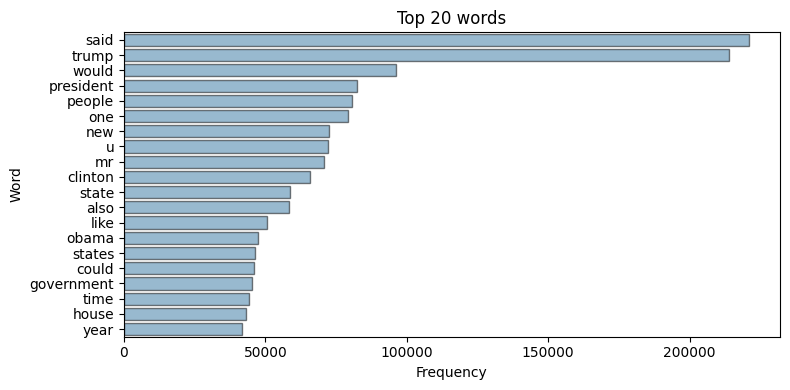

In [11]:
plot_top_words_barchart(news["clean_text"])

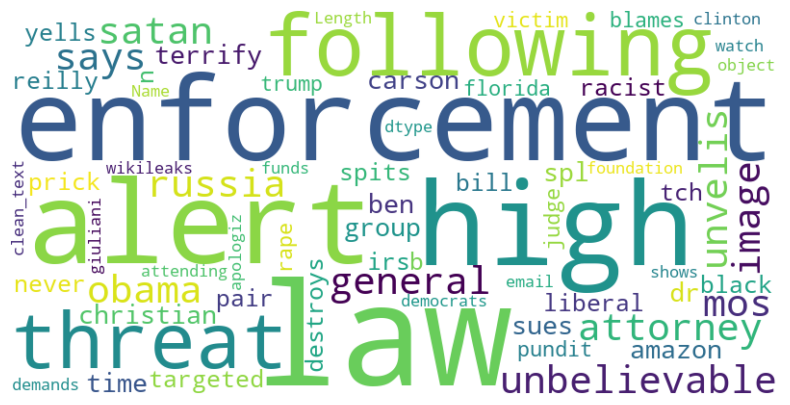

In [12]:
fake_news = news["is_fake"] == 1
plot_wordcloud(news[fake_news]["clean_text"])

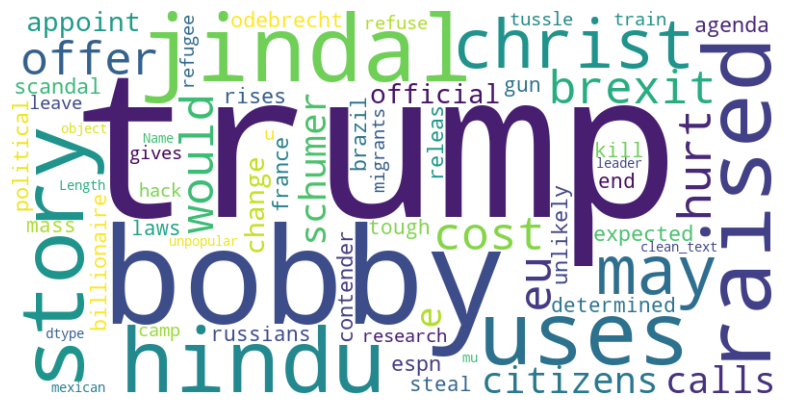

In [13]:
real_news = news["is_fake"] == 0
plot_wordcloud(news[real_news]["clean_text"])

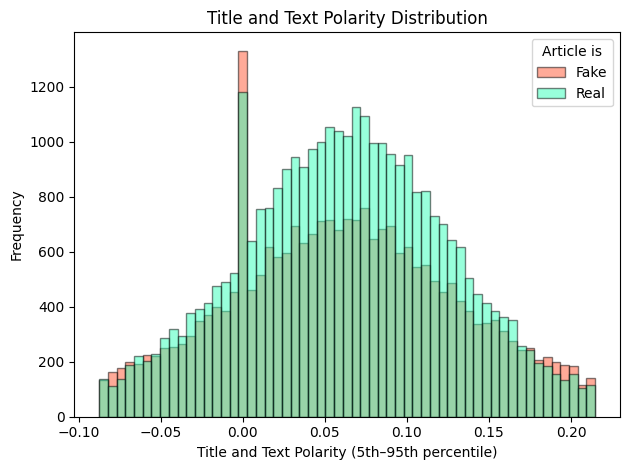

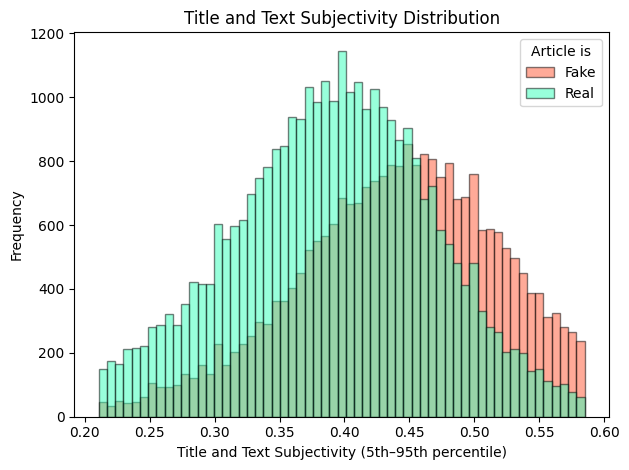

In [14]:
news['polarity'], news['subjectivity'] = zip(*news['raw_text'].apply(get_sentiment))

plot_feature_histogram(news, 'polarity', "Title and Text Polarity Distribution", "Title and Text Polarity")
plot_feature_histogram(news, 'subjectivity', "Title and Text Subjectivity Distribution", "Title and Text Subjectivity")

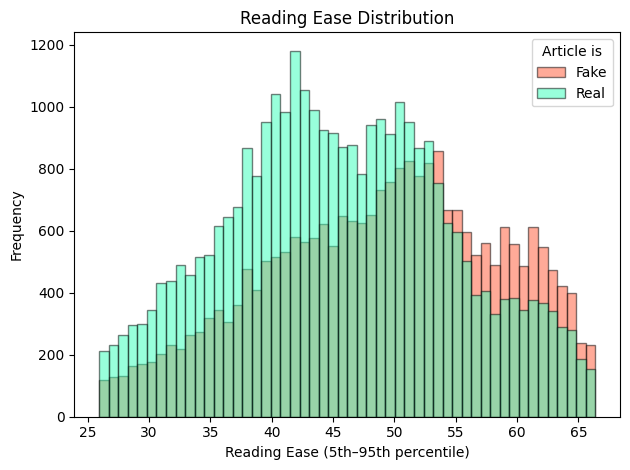

In [15]:
news["reading_ease"] = news["raw_text"].apply(textstat.flesch_reading_ease)
plot_feature_histogram(news, 'reading_ease', "Reading Ease Distribution", "Reading Ease")

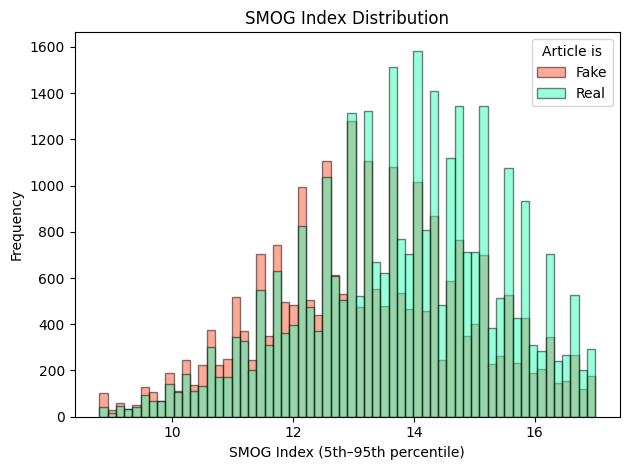

In [16]:
news["smog_index"]   = news["raw_text"].apply(textstat.smog_index)
plot_feature_histogram(news, 'smog_index', "SMOG Index Distribution", "SMOG Index")

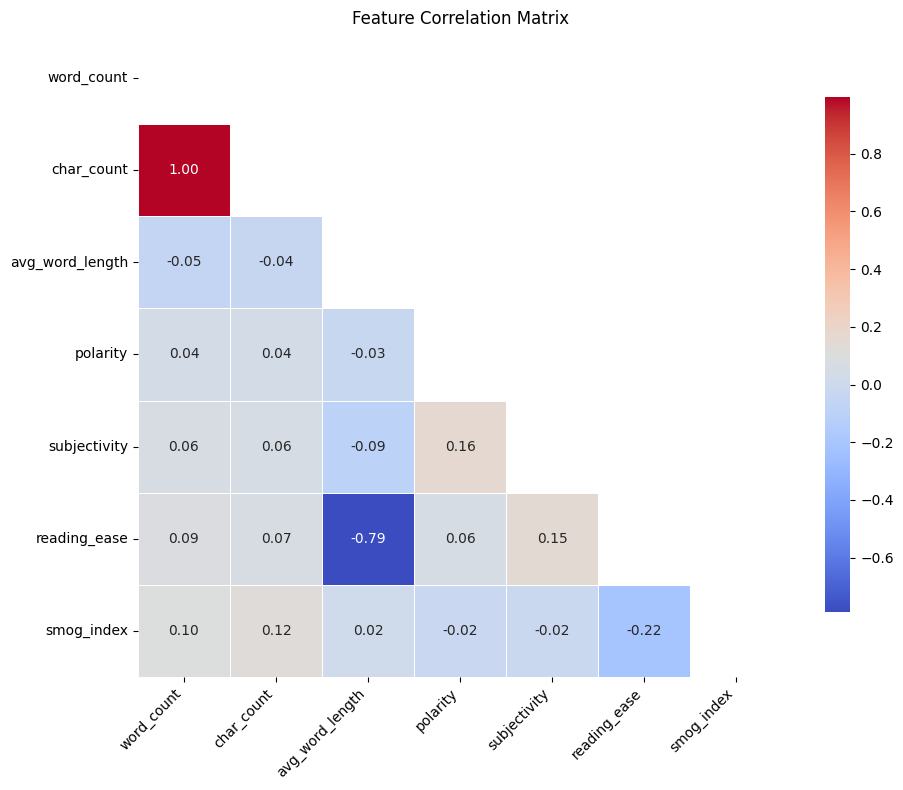

In [17]:
numeric_feats = ["word_count", "char_count", "avg_word_length", "polarity", "subjectivity", "reading_ease", "smog_index"]
plot_corr_matrix(news, numeric_feats)

In [18]:
news.describe()

,is_fake,word_count,char_count,avg_word_length,polarity,subjectivity,reading_ease,smog_index
count,63121.000000,63121.000000,63121.000000,63121.000000,63121.000000,63121.000000,63121.000000,63121.000000
mean,0.448821,558.643478,3379.253212,6.115375,0.061979,0.410053,46.647803,13.152094
std,0.497378,611.540124,3640.945559,1.102586,0.107311,0.122308,19.190810,3.475913
min,0.000000,2.000000,14.000000,3.530769,-1.000000,0.000000,-2079.400000,0.000000
25%,0.000000,253.000000,1538.000000,5.886364,0.007500,0.350432,39.260000,12.200000
50%,0.000000,415.000000,2545.000000,6.081307,0.061328,0.415100,47.220000,13.600000
75%,1.000000,689.000000,4193.000000,6.282051,0.112665,0.476316,54.730000,14.900000
max,1.000000,24243.000000,143035.000000,149.500000,1.000000,1.000000,119.190000,38.700000
